# Setup

In [1]:
# import packages
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm

In [2]:
#### Helper data loader functions
def cleanup_df(df):    
    surplus = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(surplus,axis=1)
    return df

def flatten(x):
    return [item for sublist in x for item in sublist]

def bootstrapCI(x,estimator,nIter, *args):
    u = []
    for i in tqdm(np.arange(nIter)):
        inds = np.random.RandomState(i).choice(len(x),len(x))
        boot = x[inds]
        u.append(estimator(boot, *args))
        
    p1 = len([i for i in u if i<0])/len(u) * 2
    p2 = len([i for i in u if i>0])/len(u) * 2
    p = np.min([p1,p2])
    U = np.mean(u)
    lb = np.percentile(u,2.5)
    ub = np.percentile(u,97.5)    
    return U,lb,ub,p

def corrbootstrapCI(x,y,roi, nIter):
    '''
    input: x is an array
    '''
    u = []
    for i in np.arange(nIter):
        inds = np.random.RandomState(i).choice(len(x),len(x))
        bootx = x[inds]
        booty = y[inds]
        if roi in ['Frontal']:
            u.append(pd.DataFrame([bootx, booty]).transpose().corr()[0][1])
        else:
            u.append(stats.pearsonr(bootx, booty)[0])
        
    p1 = len([i for i in u if i<0])/len(u) * 2
    p2 = len([i for i in u if i>0])/len(u) * 2
    p = np.min([p1,p2])
    U = np.mean(u)
    lb = np.percentile(u,2.5)
    ub = np.percentile(u,97.5)    
    return U,lb,ub,p

def get_trained_objs(DM):
    return np.unique(DM.label.values)

def get_prob_timecourse(iv,DM,version='4way'):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]    
    
    if version=='4way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        c1 = control_objs[0]
        c2 = control_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t1].groupby(iv)['c2_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c2_prob'].mean().values)).mean(0) ## control timecourse    
    elif version=='3way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c_prob'].mean().values)).mean(0) ## control timecourse
        
    elif version=='2way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        
        control = np.zeros(len(foil)) 
        
    return target, foil, control

# now instead of getting the mean of target, foil, control for each iv, 
# you can also pass a function of target and foil to get_prob_timecourse (eg `lambda target, foil: target-foil`)
# and get the iv-timecourse for the output of that instead
# (this enables performing operations on target and foil data before means are taken for each iv)
def get_prob_timecourse(iv,DM,func=None,version='4way'): 
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]    
    
    t1 = trained_objs[0]
    t2 = trained_objs[1]
    c1 = control_objs[0]
    c2 = control_objs[1]
    
    if func:
        return np.vstack((DM[DM.label==t1].groupby('trial_num').apply(lambda x: func(x['t1_prob'], x['t2_prob'])).values,
                          DM[DM.label==t2].groupby('trial_num').apply(lambda x: func(x['t2_prob'], x['t1_prob'])).values)).mean(0)
    else:
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t1].groupby(iv)['c2_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c2_prob'].mean().values)).mean(0) ## control timecourse    
        return target, foil, control
    
def clf(target, foil):
    if clfmeasure == 't-f':
        return np.mean(target-foil)
    elif clfmeasure == 't+f':
        return np.mean(target+foil)
    elif clfmeasure == 't':
        return np.mean(target)
    else:
        return np.mean(foil)

In [3]:
version = '4way'
logged = True
tag = 'logged' if logged else 'raw'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag))
#ALLDM = pd.read_csv('./formatted_partial_sketch.csv')
ALLDM = cleanup_df(ALLDM)

# Implementation

Here's the plan. For each ROI...
1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
2. Generate a subject_num length vector consisting of each subject's pre-post change measure in the same order as they are in the matrix.
3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix and the prepost change vector is the time course we're looking to understand for this ROI.

In [ ]:
# Here's the plan. For each ROI...
# 1. Generate a subject-by-iv matrix where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
# 2. Generate a subject_num length vector consisting of each subject's pre-post change measure in the same order as they are in the matrix.
# 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix and the prepost change vector is the time course we're looking to understand for this ROI.

# some subjects missing in prepost
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
prepost['IDs'] = [int(each[:each.find('_')]) for each in prepost['IDs'].values]
missing_subj = np.setdiff1d(np.unique(ALLDM['subj']), prepost['IDs'])
mask = ALLDM['subj'].isin(missing_subj)
ALLDM = ALLDM[~mask]
ALLDM.sort_values('subj')
prepost.sort_values('IDs')
subs = np.unique(ALLDM.subj.values)

subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
variants = ['t', 'f','t-f', 'txf']
ivs = ['trial_num'] #['run_num','trial_num']#,'time_point']
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])

roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral'])
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC', 'Frontal', 'Parietal', 'supraMarginal', 'Insula', 'postCentral', 'preCentral'])

takeDiffDifference = True

for anchored in [True, False]:
    specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')
    for this_iv in ivs:
        for variant in variants:
            for this_roi in roi_list:
                # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
                # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
                scores = []
                for sub in subs:
                    inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                    clfmeasure = variant
                    scores.append(get_prob_timecourse(this_iv,ALLDM[inds], func=clf))
                scores = np.vstack(scores)

                # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
                # in the same order as they are in the matrix.
                if anchored:
                    recog = prepost['trained_{}'.format(this_roi)].values
                    recog -= prepost['control_{}'.format(this_roi)].values if takeDiffDifference else 0
                else:
                    recog = prepost['tradiff_{}'.format(this_roi)].values
                    recog -= prepost['condiff_{}'.format(this_roi)].values if takeDiffDifference else 0

                # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
                # and the prepost change vector is the time course we're looking to understand for this ROI.
                if this_roi == 'Frontal':
                    corcourse = [pd.DataFrame([scores[:,i], recog]).transpose().corr()[0][1] for i in range(np.shape(scores)[1])]
                else:
                    corcourse = [stats.pearsonr(scores[:,i],recog)[0] for i in range(np.shape(scores)[1])]

                bootstrap = [corrbootstrapCI(scores[:,i],recog, this_roi, 1000) for i in range(np.shape(scores)[1])]
                lesserror, pluserror = [b[1] for b in bootstrap], [b[2] for b in bootstrap]

                fig = plt.figure(figsize=(8,4))
                plt.plot(corcourse, 'ro', label='data')

                plt.axhline(y=0.0,linestyle='dashed')
                plt.ylim((-.6,.6))
                plt.ylabel('corr({}, prepost_difference)'.format(variant))
                plt.xlabel(this_iv)
                plt.title('ROI: {}'.format(this_roi))
                plt.fill_between(np.arange(len(corcourse)), lesserror,pluserror, alpha=.2)

                if not os.path.exists('./drawrecogcourse_{}_{}'.format(*specs)):
                    os.makedirs('./drawrecogcourse_{}_{}'.format(*specs))
                plt.tight_layout()
                plt.savefig('./drawrecogcourse_{}_{}/{}_{}.png'.format(*specs, this_roi,variant))
                plt.close(fig)

Let's try a variant that plots t and f correlations with prepost separately/on the same graph.

In [ ]:
subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
ivs = ['trial_num'] #['run_num','trial_num']#,'time_point']
takeDiffDifference = True

roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])

roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral'])
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC', 'Frontal', 'Parietal', 'supraMarginal', 'Insula', 'postCentral', 'preCentral'])

for anchored in [True, False]:
    specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')
    for this_iv in ivs:
        for this_roi in roi_list:
            T, F = [], []
            for sub in subs:
                inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
                num_ivs = len(t)
                T.append(t)
                F.append(f)
            T, F = np.vstack(T), np.vstack(F)

            if anchored:
                recog = prepost['trained_{}'.format(this_roi)].values
                recog -= prepost['control_{}'.format(this_roi)].values if takeDiffDifference else 0
            else:
                recog = prepost['tradiff_{}'.format(this_roi)].values
                recog -= prepost['condiff_{}'.format(this_roi)].values if takeDiffDifference else 0

            fig = plt.figure(figsize=(8,4))
            
            if this_roi == 'Frontal':
                corcourse = [pd.DataFrame([T[:,i], recog]).transpose().corr()[0][1] for i in range(np.shape(T)[1])]
            else:
                corcourse = [stats.pearsonr(T[:,i],recog)[0] for i in range(np.shape(T)[1])]
            bootstrap = [corrbootstrapCI(T[:,i],recog, this_roi, 1000) for i in range(np.shape(T)[1])]
            lesserror, pluserror = [b[1] for b in bootstrap], [b[2] for b in bootstrap]

            plt.plot(corcourse, 'ro', label='target')
            plt.fill_between(np.arange(len(corcourse)), lesserror,pluserror, alpha=.2, color = 'r')
            #plt.plot(np.arange(num_ivs), np.poly1d(np.polyfit(np.arange(num_ivs), corcourse, 1))(np.unique(np.arange(num_ivs))), 'r')

            if this_roi == 'Frontal':
                corcourse = [pd.DataFrame([F[:,i], recog]).transpose().corr()[0][1] for i in range(np.shape(F)[1])]
            else:
                corcourse = [stats.pearsonr(F[:,i],recog)[0] for i in range(np.shape(F)[1])]
            bootstrap = [corrbootstrapCI(F[:,i],recog, this_roi, 1000) for i in range(np.shape(F)[1])]
            lesserror, pluserror = [b[1] for b in bootstrap], [b[2] for b in bootstrap]

            plt.plot(corcourse, 'cv', label='foil')
            plt.fill_between(np.arange(len(corcourse)), lesserror,pluserror, alpha=.2, color='c')
            #plt.plot(np.arange(num_ivs), np.poly1d(np.polyfit(np.arange(num_ivs), corcourse, 1))(np.unique(np.arange(num_ivs))), 'c')

            plt.ylabel('cor w/ prepost difference')
            plt.xlabel(this_iv)
            plt.title('ROI: {}'.format(this_roi))
            plt.legend()

            if not os.path.exists('./drawrecogcourse_{}_{}'.format(*specs)):
                os.makedirs('./drawrecogcourse_{}_{}'.format(*specs))
            plt.tight_layout()
            plt.savefig('./drawrecogcourse_{}_{}/{}_tvsf.png'.format(specs[0], specs[1], this_roi))
            plt.close(fig)

Let's try redo-ing the original draw_contrast vs prepost differentiation analysis focusing the target and competitor scores.

In [37]:
# Here's the plan. For each ROI...
# 1. Generate a subject-by-iv matrix where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
# 2. Generate a subject_num length vector consisting of each subject's pre-post change measure in the same order as they are in the matrix.
# 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix and the prepost change vector is the time course we're looking to understand for this ROI.

subs = np.unique(ALLDM.subj.values)
variants = ['t', 'f','t-f', 'txf']
ivs = ['trial_num'] #['run_num','trial_num']#,'time_point']
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])
takeDiffDifference = True

#roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral'])
#roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC', 'Frontal', 'Parietal', 'supraMarginal', 'Insula', 'postCentral', 'preCentral'])

variants = ['t-f']
roi_list = ['V1']

for anchored in [False]:
    specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')
    for this_iv in ivs:
        for variant in variants:
            for this_roi in roi_list:

                # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
                # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
                scores = []

                for sub in subs:
                    print(sub)
                    inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                    clfmeasure = variant
                    #scores.append(np.mean(get_prob_timecourse(this_iv,ALLDM[inds], func=clf)))
                    score = get_prob_timecourse(this_iv,ALLDM[inds])
                    scores.append(np.mean(score[0]-score[1]))
                draw = np.hstack(scores) # a subject by trial matrix (31 entries with num_ivs entries each inside)

                # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
                # in the same order as they are in the matrix.
                prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
                if anchored:
                    recog = prepost['trained_{}'.format(this_roi)].values
                    recog -= prepost['control_{}'.format(this_roi)].values if takeDiffDifference else 0
                else:
                    recog = prepost['tradiff_{}'.format(this_roi)].values
                    recog -= prepost['condiff_{}'.format(this_roi)].values if takeDiffDifference else 0

                z = pd.DataFrame([draw,recog])
                z = z.transpose()
                z.columns=['draw','recog']

                ## plot 
                fig = plt.figure(figsize=(6,6))
                sns.set_context('poster')
                sns.regplot(x="draw",
                            y ="recog",
                            data=z)
                
                if this_roi == 'Frontal':
                    r = pd.DataFrame([draw, recog]).transpose().corr()[0][1]
                else:
                    r = stats.pearsonr(draw, recog)[0]
                
                plt.title('ROI: {}  r={}'.format(this_roi,np.round(r,5)))
                plt.xlabel('drawing: {}'.format(variant))
                plt.ylabel('recog: post-pre differentiation')
                if not os.path.exists('./drawrecog_{}_{}'.format(*specs)):
                    os.makedirs('./drawrecog_{}_{}'.format(*specs))
                plt.tight_layout()
                plt.savefig('./drawrecog_{}_{}/{}_{}.png'.format(specs[0], specs[1], this_roi, variant))
                plt.close(fig)    

110171
110172
111171
112171
112172
112173
113171
115174
117171
118171
118172
119171
119172
119173
119174
120171
120172
120173
123171
123173
124171
125171
125172
1121161
1130161
1202161
1203161
1206161
1206162
1206163
1207162


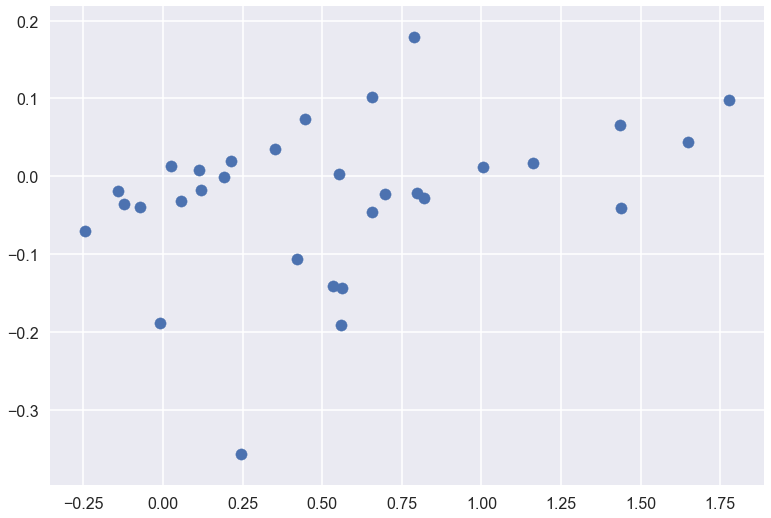

,draw,recog
0,0.213782,0.019555
1,-0.244875,-0.070491
2,0.026424,0.013466
3,0.533824,-0.140920
4,0.120252,-0.017790
5,0.818020,-0.028009
6,0.698265,-0.022599
7,1.439404,-0.041108
8,0.446440,0.073081
9,0.656711,-0.045691


In [39]:
plt.scatter(z['draw'], z['recog'])
plt.show()
z

# Follow Up: Bar Graph Summaries

In [ ]:
# this is the full thing; a la carte version is below

from scipy.stats import linregress

takeDiffDifference = True
version = '4way'
this_iv = 'trial_num'

comparison = 'correlation'
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral'])
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC', 'Frontal', 'Parietal', 'supraMarginal', 'Insula', 'postCentral', 'preCentral'])
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

def clf(target, foil):
    if clfmeasure == 't-f':
        return np.mean(target-foil)
    elif clfmeasure == 'txf':
        return np.mean(target+foil) if logged else np.mean(target*foil)
    elif clfmeasure == 't':
        return np.mean(target)
    else:
        return np.mean(foil)
    
def scoreVSdiff(subdata, this_roi):
    clfscores = [np.mean(c['clf']) for c in subdata]
    diffscores = [sub['diff'] for sub in subdata]
    
    if this_roi == 'Frontal':
        return pd.DataFrame([clfscores, diffscores]).transpose().corr()[0][1]
    else:
        return stats.pearsonr(clfscores, diffscores)[0]
    
def slope_scoreVSdiff(subdata, this_roi):
    num_ivs = 20
    diffscores = [sub['diff'] for sub in subdata]
    clfscores = [c['clf'] for c in subdata]
    
    if this_roi == 'Frontal':
        coefficients = [pd.DataFrame([[c[i] for c in clfscores], diffscores]).transpose().corr()[0][1] for i in range(num_ivs)]
    else:
        coefficients = [stats.pearsonr([c[i] for c in clfscores], diffscores)[0] for i in range(num_ivs)]
    return linregress(np.arange(num_ivs),coefficients)[0]

for logged in [True, False]:
    for anchored in [True, False]:
        for clfmeasure in ['t', 'f', 't-f', 'txf']:
            print('logged: {}; anchored: {}; clf: {}'.format(logged, anchored, clfmeasure))
            specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')
            ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,'logged' if logged else 'raw'))
            ALLDM = cleanup_df(ALLDM)
            subs = np.unique(ALLDM.subj.values)
            
            columns = []
            for this_roi in roi_list:
                scores = [get_prob_timecourse(this_iv,ALLDM[(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)], func=clf) for sub in subs]
                objs = [str(np.unique(ALLDM[(ALLDM['subj']==sub)].label.values)) for sub in subs]
                if anchored:
                    recog = prepost['trained_{}'.format(this_roi)].values
                    recog -= prepost['control_{}'.format(this_roi)].values if takeDiffDifference else 0
                else:
                    recog = prepost['tradiff_{}'.format(this_roi)].values
                    recog -= prepost['condiff_{}'.format(this_roi)].values if takeDiffDifference else 0

                columns.append([{'clf':scores[i], 'diff':recog[i], 'objs':objs[i]} for i in range(len(scores))])
            bardf = pd.DataFrame(columns).transpose()
            bardf.columns = roi_formatted
            
            
            ######## MEAN
            functionmap = {'correlation': scoreVSdiff}

            # derive from bardf the df we want to plot and the error bars we want
            meandf = pd.DataFrame([functionmap[comparison](np.array(bardf)[:,i], roi_list[i]) for i in range(len(roi_list))]).transpose()
            meandf.columns = roi_formatted
            error = [bootstrapCI(np.array(bardf)[:,i],functionmap[comparison], 1000, roi_list[i])[1:3] for i in range(len(roi_list))]

            fig = plt.figure(figsize=(17,6))
            sns.barplot(data=meandf,palette='husl',ci=None)
            plt.xlabel('ROIs')
            plt.title('Subjectwise Relationship B/t Mean({}) & PrePost Diff'.format(clfmeasure)) # 'Significance of Iteraction Term for (Diff ~ Mean(t-f) * object_assignment)'
            plt.ylabel('Mean({}) vs PrePost Relationship'.format(clfmeasure)) # 'f-test p-value'
            for i in range(len(roi_list)):
                plt.vlines(i, error[i][0], error[i][1])
            plt.tight_layout()
            if not os.path.exists('./drawrecogsum_{}_{}'.format(*specs)):
                os.makedirs('./drawrecogsum_{}_{}'.format(*specs))
            plt.tight_layout()
            plt.savefig('./drawrecogsum_{}_{}/mean_{}.png'.format(specs[0], specs[1], clfmeasure))
            plt.close(fig)
            
            
            ######### SLOPE
            functionmap = {'correlation': slope_scoreVSdiff}

            # derive from bardf the df we want to plot and the error bars we want
            meandf = pd.DataFrame([functionmap[comparison](np.array(bardf)[:,i], roi_list[i]) for i in range(len(roi_list))]).transpose()
            meandf.columns = roi_formatted
            error = []
            for i in range(len(roi_list)):
                e = bootstrapCI(np.array(bardf)[:,i],functionmap[comparison], 1000, roi_list[i])[1:3]
                error.append(e)

            fig = plt.figure(figsize=(17,6))
            sns.barplot(data=meandf,palette='husl',ci=None)
            plt.xlabel('ROIs')
            plt.title('Slope over Timepoints of Subjectwise Relationship B/t {} & Prepost Diff'.format(clfmeasure))
            plt.ylabel('Slope Over Timepoints of({}) vs PrePost Relationship'.format(clfmeasure))
            for i in range(len(roi_list)):
                plt.vlines(i, error[i][0], error[i][1])
            plt.tight_layout()
            if not os.path.exists('./drawrecogsum_{}_{}'.format(*specs)):
                os.makedirs('./drawrecogsum_{}_{}'.format(*specs))
            plt.tight_layout()
            plt.savefig('./drawrecogsum_{}_{}/slope_{}.png'.format(specs[0], specs[1], clfmeasure))
            plt.close(fig)

In [54]:
# parameters
anchored = True
takeDiffDifference = True
logged = True
clfmeasure = 'f' #['t', 'f', 't-f', 't*f']
comparison = 'correlation' # one of ['correlation', 'regression', 'itemeffects']
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])

roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral'])
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC', 'Frontal', 'Parietal', 'supraMarginal', 'Insula', 'postCentral', 'preCentral'])

specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')

preprocessing...

In [55]:
# first we want to create a dataframe that seaborn can easily bootstrap by
# we want an subject by ROI dataframe, where each entry has the subject's get_prob_timecourse() output and prepost score for the associated ROI.

def clf(target, foil):
    if clfmeasure == 't-f':
        return np.mean(target-foil)
    elif clfmeasure == 'txf':
        return np.mean(target+foil) if logged else np.mean(target*foil)
    elif clfmeasure == 't':
        return np.mean(target)
    else:
        return np.mean(foil)
    
def prepReg(clfscores, diffscores, objs):
    regdf = pd.DataFrame([clfscores, diffscores, objs]).transpose()
    regdf.columns = ['selectivity', 'diff', 'objs']
    regdf['selectivity'] = regdf['selectivity'].astype(float)
    regdf['diff'] = regdf['diff'].astype(float)
    regdf['objs'] = regdf['objs'].astype('category')
    return smf.ols(formula='diff ~ selectivity', data = regdf).fit()
    #return smf.ols(formula='diff ~ selectivity * objs', data = regdf).fit()

version = '4way'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,'logged' if logged else 'raw'))
ALLDM = cleanup_df(ALLDM)

subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
this_iv = 'trial_num'

columns = []
for this_roi in roi_list:
    scores = [get_prob_timecourse(this_iv,ALLDM[(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)], func=clf) for sub in subs]
    objs = [str(np.unique(ALLDM[(ALLDM['subj']==sub)].label.values)) for sub in subs]
    if anchored:
        recog = prepost['trained_{}'.format(this_roi)].values
        recog -= prepost['control_{}'.format(this_roi)].values if takeDiffDifference else 0
    else:
        recog = prepost['tradiff_{}'.format(this_roi)].values
        recog -= prepost['condiff_{}'.format(this_roi)].values if takeDiffDifference else 0
        
    columns.append([{'clf':scores[i], 'diff':recog[i], 'objs':objs[i]} for i in range(len(scores))])
bardf = pd.DataFrame(columns).transpose()
bardf.columns = roi_formatted

mean overall

In [ ]:
# first let's look at the mean draw_contrast score for each subject versus each subject's prepost differentiation measure. 

# define the estimator
# find the correlation between the vector of each subject's draw_contrast scores and that of each subject's differentiation scores
    
def scoreVSdiff(subdata, this_roi):
    clfscores = [np.mean(c['clf']) for c in subdata]
    diffscores = [sub['diff'] for sub in subdata]
    
    if this_roi == 'Frontal':
        return pd.DataFrame([clfscores, diffscores]).transpose().corr()[0][1]
    else:
        return stats.pearsonr(clfscores, diffscores)[0]

def controlled_scoreVSdiff(subdata):
    clfscores = [np.mean(c['clf']) for c in subdata]
    diffscores = [sub['diff'] for sub in subdata]
    objs = [sub['objs'] for sub in subdata]
    reg = prepReg(clfscores, diffscores, objs)
    return reg.params[1]
    #return reg.params[len(np.unique(objs))]

def covariate_scoreVSdiff(subdata):
    clfscores = [np.mean(c['clf']) for c in subdata]
    diffscores = [sub['diff'] for sub in subdata]
    objs = [sub['objs'] for sub in subdata]
    reg = prepReg(clfscores, diffscores, objs)
    A = np.identity(len(reg.params))
    InteractionTest = A[len(np.unique(objs))+1:,:]
    return reg.f_test(InteractionTest).pvalue

functionmap = {'correlation': scoreVSdiff, 'regression': controlled_scoreVSdiff, 'itemeffects': covariate_scoreVSdiff}

# derive from bardf the df we want to plot and the error bars we want
meandf = pd.DataFrame([functionmap[comparison](np.array(bardf)[:,i], roi_list[i]) for i in range(len(roi_list))]).transpose()
meandf.columns = roi_formatted
error = [bootstrapCI(np.array(bardf)[:,i],functionmap[comparison], 1000, roi_list[i])[1:3] for i in range(len(roi_list))]

fig = plt.figure(figsize=(17,6))
sns.barplot(data=meandf,palette='husl',ci=None)
plt.xlabel('ROIs')
plt.title('Subjectwise Relationship B/t Mean({}) & PrePost Diff'.format(clfmeasure)) # 'Significance of Iteraction Term for (Diff ~ Mean(t-f) * object_assignment)'
plt.ylabel('Mean({}) vs PrePost Relationship'.format(clfmeasure)) # 'f-test p-value'
for i in range(len(roi_list)):
    plt.vlines(i, error[i][0], error[i][1])
plt.tight_layout()
if not os.path.exists('./drawrecogsum_{}_{}'.format(*specs)):
    os.makedirs('./drawrecogsum_{}_{}'.format(*specs))
plt.tight_layout()
plt.savefig('./drawrecogsum_{}_{}/mean_{}.png'.format(specs[0], specs[1], clfmeasure))
plt.close(fig)

slope of correlations

In [ ]:
from scipy.stats import linregress

# second, instead of taking the overall mean draw_contrast score and relating that with differentiation, 
# get the draw_contrast score for each timepoint and relate those against differentiation
# the slope of all 20 or whatever correlations is what we graph

# define the estimator
def slope_scoreVSdiff(subdata, this_roi):
    num_ivs = 20
    diffscores = [sub['diff'] for sub in subdata]
    clfscores = [c['clf'] for c in subdata]
    
    if this_roi == 'Frontal':
        coefficients = [pd.DataFrame([[c[i] for c in clfscores], diffscores]).transpose().corr()[0][1] for i in range(num_ivs)]
    else:
        coefficients = [stats.pearsonr([c[i] for c in clfscores], diffscores)[0] for i in range(num_ivs)]
    return linregress(np.arange(num_ivs),coefficients)[0]

def controlled_slopescoreVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub['diff'] for sub in subdata]
    clfscores = [c['clf'] for c in subdata]
    objs = [sub['objs'] for sub in subdata]
    coefficients = []
    for i in range(num_ivs):
        reg = prepReg([c[i] for c in clfscores], diffscores, objs)
        coefficients.append(reg.params[len(np.unique(objs))])
    return linregress(np.arange(num_ivs),coefficients)[0]

def covariate_slopescoreVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub['diff'] for sub in subdata]
    clfscores = [c['clf'] for c in subdata]
    objs = [sub['objs'] for sub in subdata]
    pvalues = []
    for i in range(num_ivs):
        reg = prepReg([c[i] for c in clfscores], diffscores, objs)
        A = np.identity(len(reg.params))
        InteractionTest = A[len(np.unique(objs))+1:,:]
        pvalues.append(reg.f_test(InteractionTest).pvalue)
    return linregress(np.arange(num_ivs),pvalues)[0]

functionmap = {'correlation': slope_scoreVSdiff, 'regression': controlled_slopescoreVSdiff, 'itemeffects': covariate_slopescoreVSdiff}

# derive from bardf the df we want to plot and the error bars we want
meandf = pd.DataFrame([functionmap[comparison](np.array(bardf)[:,i], roi_list[i]) for i in range(len(roi_list))]).transpose()
meandf.columns = roi_formatted
error = []
for i in range(len(roi_list)):
    e = bootstrapCI(np.array(bardf)[:,i],functionmap[comparison], 1000, roi_list[i])[1:3]
    error.append(e)

fig = plt.figure(figsize=(17,6))
sns.barplot(data=meandf,palette='husl',ci=None)
plt.xlabel('ROIs')
plt.title('Slope over Timepoints of Subjectwise Relationship B/t {} & Prepost Diff'.format(clfmeasure))
plt.ylabel('Slope Over Timepoints of({}) vs PrePost Relationship'.format(clfmeasure))
for i in range(len(roi_list)):
    plt.vlines(i, error[i][0], error[i][1])
plt.tight_layout()
if not os.path.exists('./drawrecogsum_{}_{}'.format(*specs)):
    os.makedirs('./drawrecogsum_{}_{}'.format(*specs))
plt.tight_layout()
plt.savefig('./drawrecogsum_{}_{}/slope_{}.png'.format(specs[0], specs[1], clfmeasure))
plt.close(fig)

# ROI Correlations

For each subject, we want to produce a correlation matrix where we take the time course of different values for one ROI and relate them against the time course of another.

In [12]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

def cleanup_df(df):    
    surplus = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(surplus,axis=1)
    return df

version = '4way'

In [ ]:
for logged in [True, False]:
    ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag))
    ALLDM = cleanup_df(ALLDM)
    
    subs = np.unique(ALLDM.subj.values)
    variants = ['t', 'f','t-f', 'txf']
    ivs = ['trial_num'] #['run_num','trial_num']#,'time_point']
    roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusi\nform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])
    roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])
    
    roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral'])
    roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC', 'Frontal', 'Parietal', 'supraMarginal', 'Insula', 'postCentral', 'preCentral'])
    
    anchored = True
    takeDiffDifference = True
    specs = ('anchored' if anchored else 'unanchored', 'logged' if logged else 'raw')

    for this_iv in ivs:
        for variant in variants:

            corrs = []
            for sub in subs:

                # so for each subject we want their probability time course for the set variant
                scores = []
                for this_roi in roi_list:
                    inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                    clfmeasure = variant
                    scores.append(get_prob_timecourse(this_iv,ALLDM[inds], func=clf))
                corrs.append(np.corrcoef(np.vstack(scores)))
            corr = np.mean(np.array(corrs), axis=0)

            # Generate a mask for the upper triangle
            mask = np.zeros_like(corr, dtype=np.bool)
            mask[np.triu_indices_from(mask)] = True

            # Set up the matplotlib figure
            f, ax = plt.subplots(figsize=(11, 9))

            # Generate a custom diverging colormap
            cmap = sns.diverging_palette(220, 10, as_cmap=True)

            # Draw the heatmap with the mask and correct aspect ratio
            sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0, xticklabels=roi_formatted, yticklabels=roi_formatted,
                        square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
            plt.title('ROIwise Correlation Matrix: {} {}'.format(specs[1], variant))
            plt.savefig('./corrmatrices/{}_matrix_{}.png'.format(clfmeasure, specs[1]))

Something similar next, except focusing on prepost differentiation measures and not averaging between subjects. Extract from the prepost dataframe an ROI-

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

def cleanup_df(df):    
    surplus = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(surplus,axis=1)
    return df

version = '4way'
logged = False
tag = 'logged' if logged else 'raw'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag))
#ALLDM = pd.read_csv('./formatted_partial_sketch.csv')
ALLDM = cleanup_df(ALLDM)

prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

subs = np.unique(ALLDM.subj.values)
variants = ['t', 'f','t-f', 'txf']
ivs = ['trial_num'] #['run_num','trial_num']#,'time_point']
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusi\nform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])

roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'Frontal', 'Parietal', 'supra\nmarginal', 'Insula', 'post\nCentral', 'preCentral'])
roi_list = np.array(['V1','V2','LOC','IT','fusiform','parahippo', 'PRC', 'ento','hipp','mOFC', 'Frontal', 'Parietal', 'supraMarginal', 'Insula', 'postCentral', 'preCentral'])

takeTrainedControlDifference = True

In [ ]:
for anchored in [True, False]:
    # generate the correlation coefficient
    specs = ('Anchored' if anchored else 'Unanchored', 'logged' if logged else 'raw')
    recogs = []
    for this_roi in roi_list:
        if anchored:
            recog = prepost['trained_{}'.format(this_roi)].values
            recog -= prepost['control_{}'.format(this_roi)].values if takeTrainedControlDifference else 0
        else:
            recog = prepost['tradiff_{}'.format(this_roi)].values
            recog -= prepost['condiff_{}'.format(this_roi)].values if takeTrainedControlDifference else 0
        recogs.append(recog)
    corr = np.array(pd.DataFrame(recogs).transpose().corr())

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-0.2, center=0, xticklabels=roi_formatted, yticklabels=roi_formatted,
                square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('ROIwise Correlation Matrix: {} Prepost Differentiation'.format(specs[0]))
    plt.savefig('./corrmatrices/prepost_matrix_{}.png'.format(specs[0]))

In [ ]:
np.array(pd.DataFrame(recogs).transpose().corr())

In [ ]:
pd.DataFrame(np.corrcoef(np.array(recogs)))